# Preamble

Using a simpler LSTM model based on one found in [Learning the Enigma with Recurrent Neural Networks by Sam Greydanus](https://doi.org/10.48550/arXiv.1708.07576), we manage an effective Seq2Seq translation between caesar cipher encrypted text and the unencrypted text. This produces largely effective results even in very short training times.

## Variables

In [34]:
PAD_TOKEN = 27
SOS_TOKEN = 29
EOS_TOKEN = 28
VOCAB_SIZE = 30

In [ ]:
DATA_AMOUNT = [500000, 1000]
FIXED_LENGTH = int(DATA_AMOUNT[1]*5)
TRAIN_SPLIT = 0.8
STREAM = False

In [ ]:
BATCH_SIZE = 64
EMBEDDING_DIM = 256
HIDDEN_DIM = 3000
DROPOUT = 0.5
NUM_EPOCHS = 10
LR = 5e-4
BETAS = (0.9, 0.999)
CLIP = 1.0

## Imports

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
from modules.data_handling import get_text
from modules.data_handling import lstm_data
from modules.encryption import caesar
from modules.encryption import substitution
from modules.encryption import enigma_encryptor as enigma
from modules import metrics



from tqdm.autonotebook import tqdm
import random
import os

In [39]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Creating Data

In [41]:
encryption = lambda x: caesar.rand_encrypt(x)
# encryption = lambda x: substitution.rand_encrypt(x)
# encryption = lambda x: enigma.rand_encrypt(x)


trainData, testData = lstm_data.initialise(encryption, *DATA_AMOUNT, TRAIN_SPLIT, stream=STREAM, fixed_length=FIXED_LENGTH )
train_loader, test_loader = lstm_data.data2loader(trainData, testData, BATCH_SIZE=BATCH_SIZE)

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

# Model


The model used borrows heavily from a paper I found on exactly this topic to which I am very grateful called [Learning the Enigma with Recurrent Neural Networks by Sam Greydanus](https://doi.org/10.48550/arXiv.1708.07576).

In [42]:
class Seq2Seq(nn.Module):
    def __init__(self, input_dim=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, dropout=DROPOUT):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = self.dropout(self.embedding(x))
        x, (hidden, cell) = self.rnn(x)
        return self.fc_out(x)

In [43]:
model = Seq2Seq().to(device)
if os.name != "nt":
    model = torch.compile(model)
    print("compiled")
model

compiled


/home/tristan/repos/venvs/code-breaking-nn/lib/python3.13/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


OptimizedModule(
  (_orig_mod): Seq2Seq(
    (embedding): Embedding(30, 256)
    (rnn): LSTM(256, 300, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
    (fc_out): Linear(in_features=300, out_features=30, bias=True)
  )
)

In [44]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)


model.apply(init_weights)

OptimizedModule(
  (_orig_mod): Seq2Seq(
    (embedding): Embedding(30, 256)
    (rnn): LSTM(256, 300, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
    (fc_out): Linear(in_features=300, out_features=30, bias=True)
  )
)

# Training

In [45]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 686,310 trainable parameters


In [ ]:
optimiser = optim.Adam(model.parameters(), lr=LR, betas=BETAS)
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

In [47]:
def train_fn(model, clip, data_loader=train_loader, optimiser=optimiser, loss_fn=loss_fn,  device=device):
    model.train()
    epoch_loss = 0
    for i, (X, y) in enumerate(data_loader):
        X, y = X.to(device).permute(1, 0), y.to(device).permute(1, 0)
        optimiser.zero_grad()
        output = model(X)
        loss = metrics.loss(output, y, loss_fn)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimiser.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [48]:
def evaluate_fn(model, data_loader=test_loader, loss_fn=loss_fn, device=device):
    model.eval()
    epoch_loss = 0
    errors = []
    with torch.inference_mode():
        for i, (X, y) in enumerate(data_loader):
            X, y = X.to(device).permute(1, 0), y.to(device).permute(1, 0)
            output = model(X)
            errors.extend(metrics.error_rate(output, y))
            loss = metrics.loss(output, y, loss_fn)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader), errors


In [51]:
for epoch in tqdm(range(NUM_EPOCHS)):
    train_loss = train_fn(
        model=model,
        clip=CLIP,
    )
    valid_loss, errors = evaluate_fn(
        model,
    )
    print(f"Train Loss: {train_loss:.3f} | Test Loss: {valid_loss:.3f} | Mean test errors: {metrics.error_stats(errors)[0]:.1f}")


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.414 | Test Loss: 0.223 | Mean test errors: 29.654
Train Loss: 0.200 | Test Loss: 0.147 | Mean test errors: 23.0355
Train Loss: 0.128 | Test Loss: 0.084 | Mean test errors: 15.4424


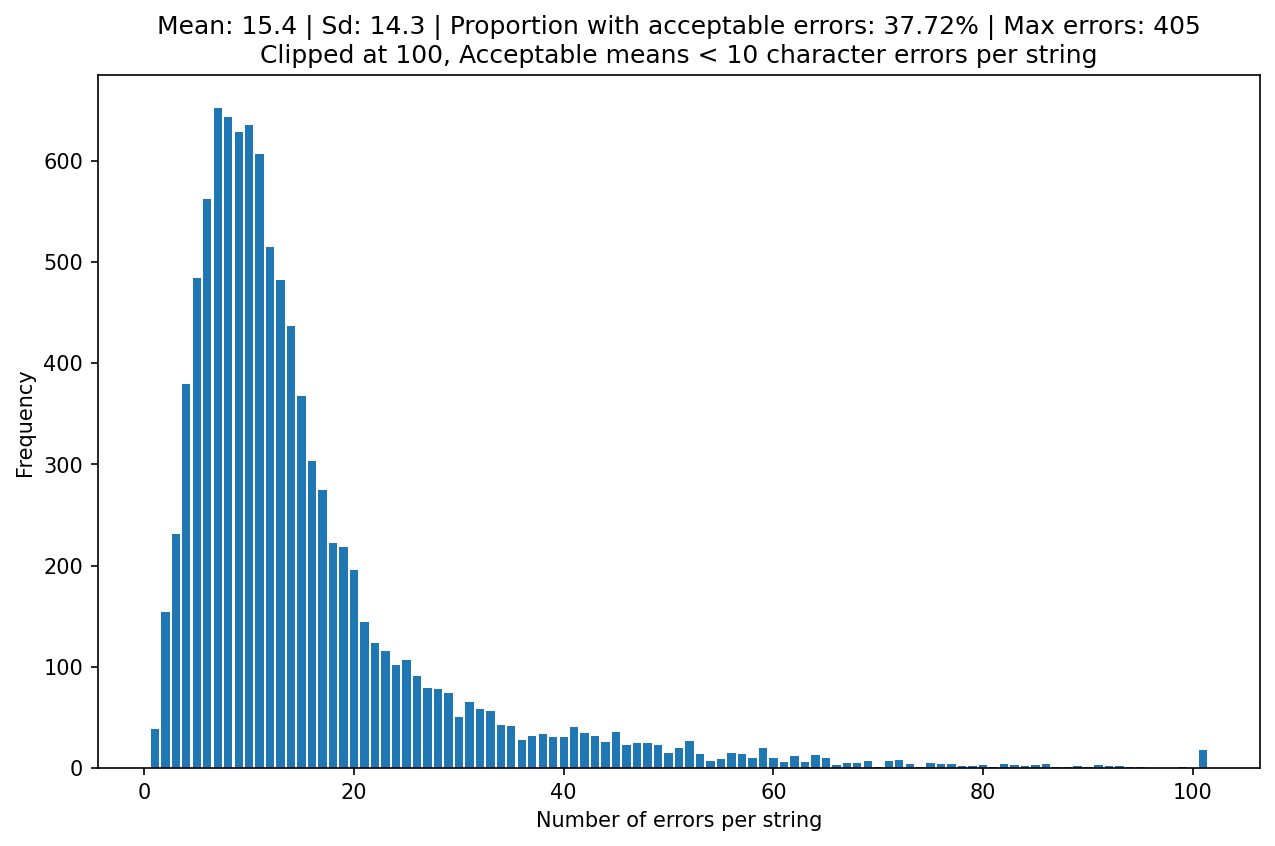

In [54]:
metrics.plot_errors(errors)

# Example useage

In [55]:
model.eval()
test_string = "The quick brown fox jumps over the lazy dog"
true_key = 14
enc_text = encryption(test_string)
print(f"Original Text: '{test_string}'")
print(f"Encrypted Text: '{enc_text}'")

input_tensor = torch.tensor([SOS_TOKEN] + get_text.string2_num_list(enc_text) + [EOS_TOKEN], dtype=torch.long).unsqueeze(1).to(device)

with torch.inference_mode():
    trg_tensor = torch.zeros(len(input_tensor), 1, dtype=torch.long).to(device)
    output = model(input_tensor)
predicted_indexes = output.argmax(2).squeeze(1)
predicted_chars = []
for idx in predicted_indexes:
    if idx.item() == EOS_TOKEN:
        break
    if idx.item() == 0:
        predicted_chars.append(" ")
    else:
        predicted_chars.append(chr(idx.item() -1 + ord('a')))

predicted_text = "".join(predicted_chars)
print(f"Model Prediction (Text): {predicted_text}")

Original Text: 'The quick brown fox jumps over the lazy dog'
Encrypted Text: 'hvs eiwqy pfckb tcl xiadg cjsf hvs zonm rcu'
Model Prediction (Text):  ahe fuico brown fou mesls ooen the wakn dor


# Save the Model

In [ ]:
torch.save(obj=model.state_dict(), f="models/01_LSTM.pt")